# MEG Exercise

## Questions

* How do they define a bad channel in MEG data?
* What is cross-talk correlation information?
* What is calibration info about?
* Have I copied the right files in the first place?
* What are the channels that I have in MEG or EEG data?
* How do we select values for band-filtering? (look at wiki, as Alex has suggested)
* What is evoked plot is about? Answer the questions related to the evoked and topomaps
* What is optimal shrinkage for noise covariance matrix? What is noise covariance matrix?
* If compute covariance returns a list of estimators should I pick the first one to plot, since it is the best one?
* Whitening of the evoked data, should it be done on every stimulus seperately?
* How to select sphere radius for volume sources?
* How do we select reject parameters for ICA? Why do I have problems with two sets of indices for EOG?

In [53]:
from os import path
from collections import defaultdict

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

import mne
from mne.preprocessing import maxwell_filter

%matplotlib notebook

In [2]:
data_path = '/home/okozyn/Projects/inria/meg_exercise/data'

subjects = ['CC320359', 'CC620085', 'CC721504']
states = ['passive', 'rest', 'task']
bad_channels = {key: defaultdict(list) for key in subjects}

bad_channels['CC320359']['passive'] = ['MEG0733']
bad_channels['CC721504']['passive'] = ['MEG0612', 'MEG2442']

sel_subject = subjects[2]
sel_state = states[0]

raw_fname = path.join(data_path, f'{sel_subject}/{sel_state}/{sel_state}_raw.fif')
raw_empty_room_path = path.join(data_path, f'{sel_subject}/emptyroom_{sel_subject}.fif')
cross_talk_corr_info_path = path.join(data_path, 'ct_sparse.fif')
calib_path = path.join(data_path, 'sss_cal.dat')


raw = mne.io.read_raw_fif(raw_fname)
raw_empty_room = mne.io.read_raw_fif(raw_empty_room_path)

Opening raw data file /home/okozyn/Projects/inria/meg_exercise/data/CC721504/passive/passive_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 63000 ... 209999 =     63.000 ...   209.999 secs
Ready.
Current compensation grade : 0
Opening raw data file /home/okozyn/Projects/inria/meg_exercise/data/CC721504/emptyroom_CC721504.fif...
Isotrak not found
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_s

<ipython-input-2-19cc1850c0fe>:20: RuntimeWarning: This filename (/home/okozyn/Projects/inria/meg_exercise/data/CC721504/emptyroom_CC721504.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_empty_room = mne.io.read_raw_fif(raw_empty_room_path)


In [3]:
bad_channels

{'CC320359': defaultdict(list, {'passive': ['MEG0733']}),
 'CC620085': defaultdict(list, {}),
 'CC721504': defaultdict(list, {'passive': ['MEG0612', 'MEG2442']})}

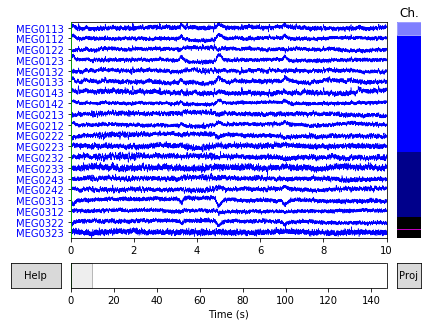

In [4]:
_ = raw.plot(group_by='type')

## Maxwell Filtering

In [5]:
raw.info['bads'] = bad_channels[sel_subject][sel_state]
raw_sss = maxwell_filter(raw, cross_talk=cross_talk_corr_info_path, calibration=calib_path)

Maxwell filtering raw data
    Loading raw data from disk
    Bad MEG channels being reconstructed: ['MEG0612', 'MEG2442']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY


<ipython-input-5-967b1539439a>:2: RuntimeWarning: 102 T1/T2 magnetometer channel types found. If using SSS, it is advised to replace coil types using "fix_mag_coil_types".
  raw_sss = maxwell_filter(raw, cross_talk=cross_talk_corr_info_path, calibration=calib_path)


        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.3°)
    Automatic origin fit: head of radius 89.6 mm
    Using origin -3.1, 6.3, 42.4 mm in the head frame
        Using 90/95 harmonic components for    0.000  (75/80 in, 15/15 out)
    Processing 14 data chunks
[done]


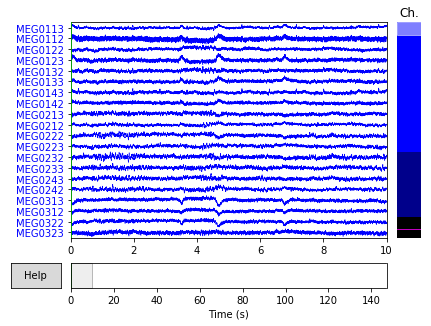

In [7]:
_ = raw_sss.plot(group_by='type')

## Bandpass Filtering

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


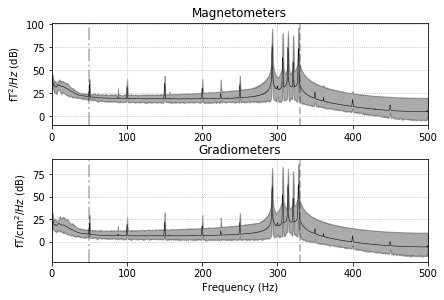

In [8]:
# PSD - power spectral density
_ = raw_sss.plot_psd(area_mode='range', show=False, average=True)

Setting up band-pass filter from 0.4 - 45 Hz
l_trans_bandwidth chosen to be 0.4 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 8251 samples (8.251 sec) selected
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


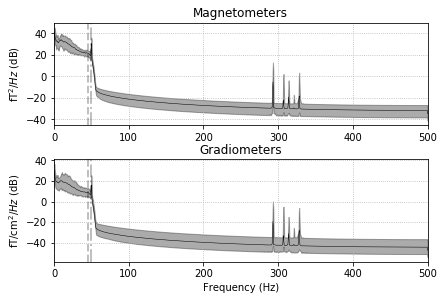

In [9]:
# filtering is done in-place
# Maxwell filter works as high-pass filter with the cut-off frequency of 0.1 Hz
# To choose between low-, high-, or band-pass we need to 
# l_freq < h_freq: band-pass filter
# l_freq > h_freq: band-stop filter
# l_freq is not None and h_freq is None: high-pass filter
# l_freq is None and h_freq is not None: low-pass filter

# h_freq value was taken from David's report
raw_sss.filter(0.4, 45)

_ = raw_sss.plot_psd(area_mode='range', show=False, average=True)

## Epoch rejection

In MNE, epoch refers to a collection of single trials or short segments of time locked raw data. STI stands for stimulus channel.
[Tutorial Link](https://martinos.org/mne/dev/auto_tutorials/plot_epoching_and_averaging.html?highlight=epoch%20rejection)

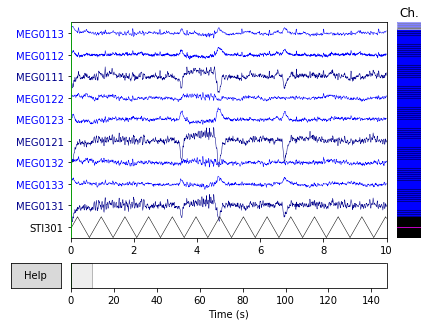

In [10]:
order = np.arange(raw.info['nchan'])
# We exchange the plotting order of two channels
# to show the trigger channel as the 10th channel.
order[9] = 326
order[326] = 9

_ = raw_sss.plot(n_channels=10, order=order)

120 events found
Event IDs: [6 7 8 9]


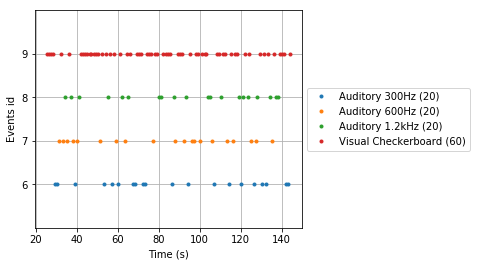

[[88357     0     9]
 [89357     0     9]
 [90224     0     9]
 [91208     0     9]
 [92208     0     6]]


In [11]:
event_id = {'Auditory 300Hz': 6, 'Auditory 600Hz': 7,
             'Auditory 1.2kHz': 8, 'Visual Checkerboard': 9}
event_id_tup = tuple(event_id.keys())
# STI301 gives some periodic stimulus
events = mne.find_events(raw_sss)

_ = mne.viz.plot_events(events, raw_sss.info['sfreq'], raw_sss.first_samp, event_id = event_id)
print(events[:5, :])

The event list contains three columns. The first column corresponds to **sample number**. To convert this to seconds, you should divide the sample number by the used sampling frequency. The second column is reserved for the old value of the trigger channel at the time of transition, but is currently not in use. The third column is the **trigger id** (amplitude of the pulse).


This is because Neuromag recordings have an attribute **first_samp** which refers to the offset between the system start and the start of the recording. Our data has a first_samp equal to 25800. This means that the first sample you see with raw.plot is the sample number 25800.

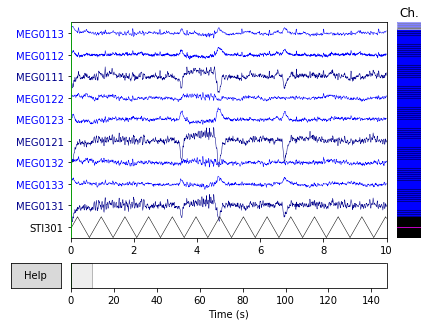

In [12]:
_ = raw_sss.plot(events=events, n_channels=10, order=order)

In [13]:
# epoch time-range in seconds
tmin, tmax = -0.2, 0.5
picks = mne.pick_types(raw_sss.info, meg=True, eeg=False, eog=True)

baseline = (None, 0.0)
reject = {'mag': 4e-12, 'eog': 200e-6}
epochs = mne.Epochs(raw_sss, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=baseline, reject=reject, picks=picks)

120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 120 events and 701 original time points ...
    Rejecting  epoch based on EOG : ['EOG061']
    Rejecting  epoch based on EOG : ['EOG062']
    Rejecting  epoch based on EOG : ['EOG062']
    Rejecting  epoch based on EOG : ['EOG062']
    Rejecting  epoch based on EOG : ['EOG062']
    Rejecting  epoch based on EOG : ['EOG062']
    Rejecting  epoch based on EOG : ['EOG062']
    Rejecting  epoch based on EOG : ['EOG062']
8 bad epochs dropped
Loading data for 20 events and 701 original time points ...


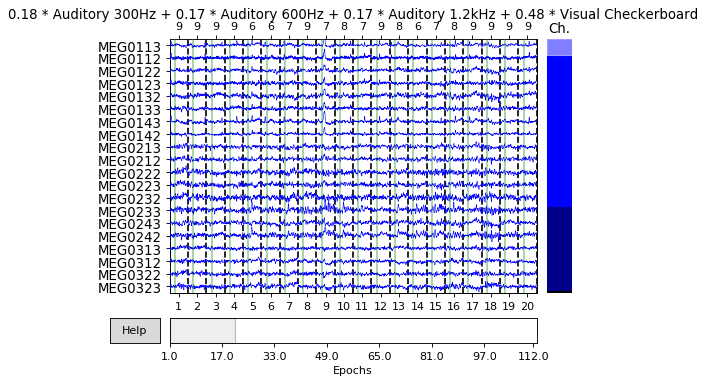

In [15]:
_ = epochs.plot(block=True)

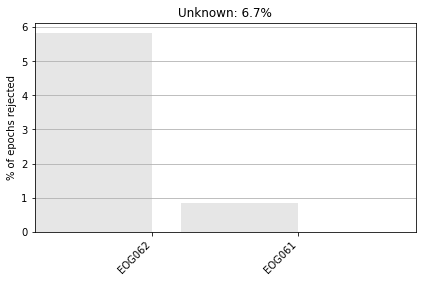

In [16]:
_ = epochs.plot_drop_log()

## Evoked Responses

In [18]:
picks = mne.pick_types(epochs.info, meg=True, eog=True)

evoked_1 = epochs[event_id_tup[0]].average(picks=picks) # ???
evoked_2 = epochs[event_id_tup[-1]].average(picks=picks)

### Evoked Response for the 300Hz Auditory Stimulus

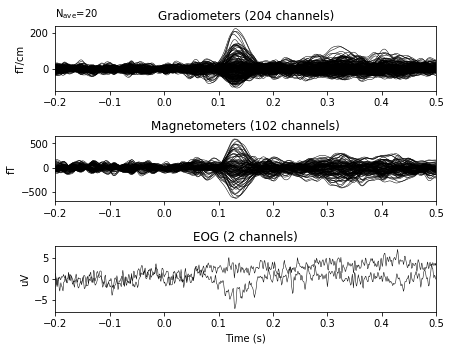

In [19]:
_ = evoked_1.plot(time_unit='s')

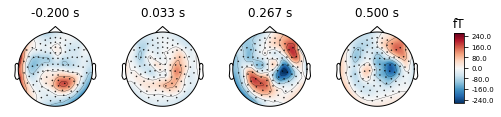

In [20]:
# parameter are from tutorial
# https://martinos.org/mne/stable/auto_examples/visualization/plot_evoked_topomap.html

_ = evoked_1.plot_topomap(ch_type='mag', time_unit='s')

### Evoked Responses for the Visual Checkerboard Stimulus

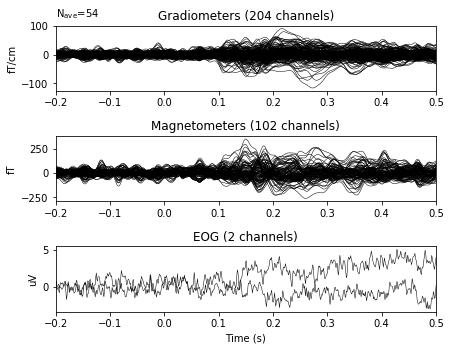

In [21]:
_ = evoked_2.plot(time_unit='s')

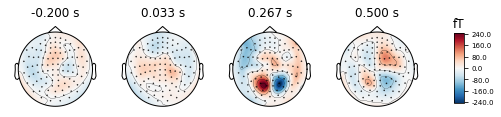

In [22]:
_ = evoked_2.plot_topomap(ch_type='mag', time_unit='s')

## Covariance Matrix

Use pre-stimulus baseline to get noise covariance matrix.
[Whitening Example](https://mne-tools.github.io/0.12/auto_examples/visualization/plot_evoked_whitening.html)

In [23]:
noise_cov_baseline = mne.compute_covariance(epochs, tmax=0, method='empirical', return_estimators=True)
# _ = noise_cov_baseline.plot(epochs.info, proj=True)

print('Covariance estimates sorted from the best to worst')
# for c in noise_cov_baseline:
#     print("%s : %s" % (c['method'], c['loglik']))

Loading data for 20 events and 701 original time points ...
Loading data for 19 events and 701 original time points ...
Loading data for 19 events and 701 original time points ...
Loading data for 54 events and 701 original time points ...
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 22512
[done]
Covariance estimates sorted from the best to worst


TypeError: string indices must be integers

    The projection vectors do not apply to these channels.


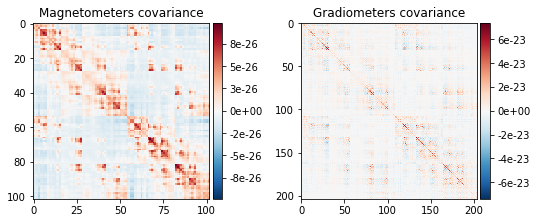

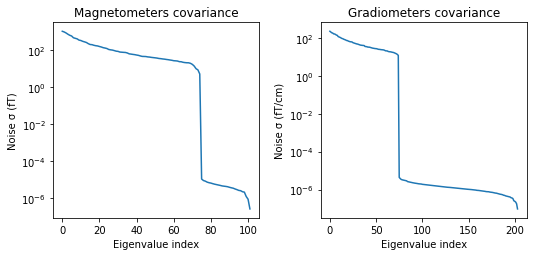

In [24]:
_ = noise_cov_baseline.plot(epochs.info, proj=True)

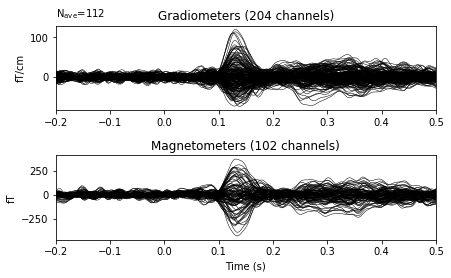

0 projection items activated
estimated rank (mag + grad): 75
0 projection items activated
estimated rank (mag + grad): 75
SSS has been applied to data. Showing mag and grad whitening jointly.
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
    Created the whitener using a noise covariance matrix with rank 75 (231 small eigenvalues omitted)


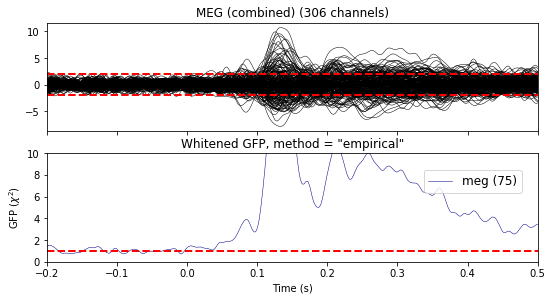

In [25]:
evoked_total = epochs.average()
_ = evoked_total.plot()
# plot the whitened evoked data for to see if baseline signals match the
# assumption of Gaussian white noise from which we expect values around
# 0 with less than 2 standard deviations. For the Global field power we expect
# a value of 1.
_ = evoked_total.plot_white(noise_cov_baseline)

## Empty Room Noise Covariance 

In [26]:
raw_empty_room.info['bads'] = bad_channels[sel_subject][sel_state]
raw_empty_room_sss = maxwell_filter(raw_empty_room, cross_talk=cross_talk_corr_info_path,
                                    calibration=calib_path, coord_frame='meg')
raw_sss = raw_sss.filter(0.4, 45)

Maxwell filtering raw data
    Loading raw data from disk
    Bad MEG channels being reconstructed: ['MEG0612', 'MEG2442']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY


<ipython-input-26-db2f2819bad5>:3: RuntimeWarning: 102 T1/T2 magnetometer channel types found. If using SSS, it is advised to replace coil types using "fix_mag_coil_types".
  calibration=calib_path, coord_frame='meg')


        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.3°)
    Using origin 0.0, 0.0, 0.0 mm in the meg frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Processing 8 data chunks
[done]
Setting up band-pass filter from 0.4 - 45 Hz
l_trans_bandwidth chosen to be 0.4 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 8251 samples (8.251 sec) selected


Using up to 439 segments
Number of samples used : 87800
[done]
    Created an SSP operator (subspace dimension = 8)


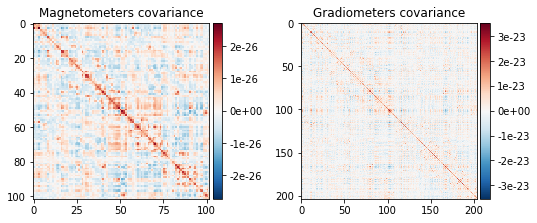

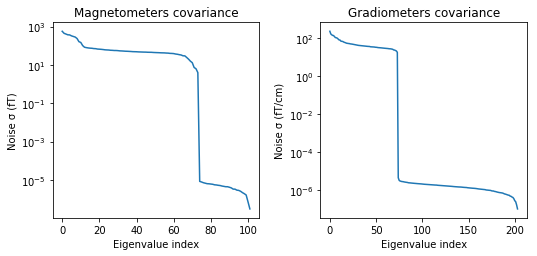

In [29]:
noise_cov_empty_room = mne.compute_raw_covariance(raw_empty_room_sss, tmin=0, tmax=None, method='empirical', return_estimators=False)
_ = noise_cov_empty_room.plot(raw_empty_room.info, proj=True)

0 projection items activated
estimated rank (mag + grad): 74
0 projection items activated
estimated rank (mag + grad): 74
SSS has been applied to data. Showing mag and grad whitening jointly.
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
    Created the whitener using a noise covariance matrix with rank 74 (232 small eigenvalues omitted)


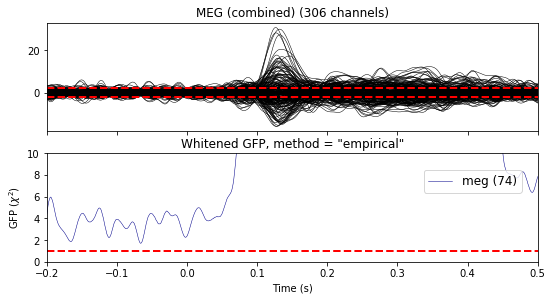

In [30]:
# empty room recordings give me an error
_ = evoked_total.plot_white(noise_cov_empty_room)

## Co-registration

In [31]:
# to launch a program
# redo coregistration!!!
# mne coreg -s CC721504 -d /home/okozyn/Projects/inria/meg_exercise/data/freesurfer --trans /home/okozyn/Projects/inria/meg_exercise/data/trans/sub-CC721504-trans.fif

subjects_dir = '../data/freesurfer'
trans = '../data/CC721504/passive/CC721504-trans.fif'

#mne.viz.plot_alignment(raw_sss.info, trans=trans, subject=subject, subjects_dir=subjects_dir)

## dSPM
BEM calculations failed for subject CC320359

In [61]:
# create forward operator
# which spacing should I take and why?

sphere = (0, 0, 0, 120)
# Left_Cerebral_Cortex 3, Right_Cerebral_Cortex 42
volume_labels = ['Left-Cerebral-Cortex', 'Right-Cerebral-Cortex']
mri_aseg_path = f'../data/freesurfer/{sel_subject}/mri/aseg.mgz'

# src = mne.setup_source_space(subject=sel_subject, subjects_dir=subjects_dir) #spacing='ico4',
src = mne.setup_volume_source_space(subject=sel_subject, subjects_dir=subjects_dir, volume_label=volume_labels, 
                                   sphere=sphere, mri=mri_aseg_path)

bem_model = mne.make_bem_model(subject=sel_subject, subjects_dir=subjects_dir) #ico=4
bem = mne.make_bem_solution(bem_model)

fwd = mne.make_forward_solution(raw_sss.info, trans, src, bem)

Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 120.0 mm
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : ../data/freesurfer/CC721504/mri/aseg.mgz

Setting up the sphere...
Surface CM = (   0.0    0.0    0.0) mm
Surface fits inside a sphere with radius  120.0 mm
Surface extent:
    x = -120.0 ...  120.0 mm
    y = -120.0 ...  120.0 mm
    z = -120.0 ...  120.0 mm
Grid extent:
    x = -125.0 ...  125.0 mm
    y = -125.0 ...  125.0 mm
    z = -125.0 ...  125.0 mm
132651 sources before omitting any.
57769 sources after omitting infeasible sources.
50733 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Selecting voxels from Left-Cerebral-Cortex
1871 sources remaining after excluding sources too far from VOI voxels
Adjusting the neighborhood info...
Surface CM = (   0.0    0.0    0.0) mm
Surface fits inside a sphere with radius  120.0 mm
Surface extent:
    x = -120.0 ...  120.0 

In [65]:
# create inverse operator
from mne.minimum_norm import make_inverse_operator, apply_inverse

inv_noise_baseline = make_inverse_operator(raw_sss.info, fwd, noise_cov_baseline, loose=1)
inv_noise_empty_room = make_inverse_operator(raw_sss.info, fwd, noise_cov_empty_room, loose=1)

Forward is not surface oriented, converting.
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
estimated rank (mag + grad): 75
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
    Created the whitener using a noise covariance matrix with rank 75 (231 small eigenvalues omitted)
Creating the depth weighting matrix...
    204 planar channels
    limit = 3648/3687 = 10.007685
    scale = 4.19489e-08 exp = 0.8
Computing inverse operator with 306 channels.
Creating the source covariance matrix
Whitening the forward solution.
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.27733
    scaling factor to adjust the trace = 8.82558e+18
Forward is not surface oriented, converting.
    No patch info available. The stand

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 112
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 75 (231 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.18 * Auditory 300Hz + 0.17 * Auditory 600Hz + 0.17 * Auditory 1.2kHz + 0.48 * Visual Checkerboard"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  93.5% variance
    Combining the current components...
    dSPM...
[done]


/home/okozyn/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


<IPython.core.display.Javascript object>


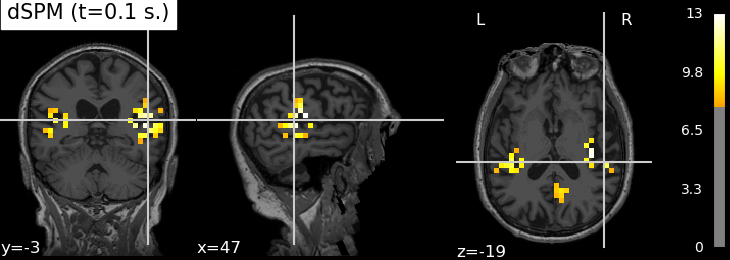

In [71]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# src = inv_noise_baseline['src']

# Compute inverse solution
stc = apply_inverse(evoked_total, inv_noise_baseline, lambda2, method)
stc.crop(0.0, 0.2)

# plots of surface results
# _ = stc.plot(subjects_dir=subjects_dir, initial_time=0.26, hemi='lh',
#              backend='matplotlib', verbose='error')

# _ = stc.plot(subjects_dir=subjects_dir, initial_time=0.26, hemi='rh',
#              backend='matplotlib', verbose='error')

# Export result as a 4D nifti object
img = stc.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, '%s-%s_inverse-noise_base.nii.gz' % (sel_subject, method))

t1_fname = f'../data/freesurfer/{sel_subject}/mri/T1.mgz'

# Plotting with nilearn ######################################################
plot_stat_map(index_img(img, 150), t1_fname, threshold=8.,
              title='%s (t=%.2f s.)' % (method, stc.times[150]))
plt.show()

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 112
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 74 (232 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.18 * Auditory 300Hz + 0.17 * Auditory 600Hz + 0.17 * Auditory 1.2kHz + 0.48 * Visual Checkerboard"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  97.9% variance
    Combining the current components...
    dSPM...
[done]


/home/okozyn/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


<IPython.core.display.Javascript object>


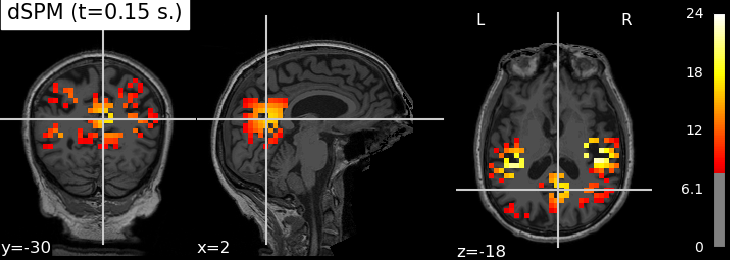

In [72]:
# Compute inverse solution
stc = apply_inverse(evoked_total, inv_noise_empty_room, lambda2, method)
stc.crop(0.0, 0.2)

# Export result as a 4D nifti object
img = stc.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, '%s-%s_inverse-noise_eroom.nii.gz' % (sel_subject, method))

t1_fname = f'../data/freesurfer/{sel_subject}/mri/T1.mgz'

# Plotting with nilearn ######################################################
plot_stat_map(index_img(img, 150), t1_fname, threshold=8.,
              title='%s (t=%.2f s.)' % (method, stc.times[150]))
plt.show()

## Independent Component Analysis (ICA)

In [81]:
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs

reject = dict(mag=5e-12, grad=4000e-13)

ica = ICA(n_components=0.95, method='fastica', random_state=0, max_iter=100)
picks_ica = mne.pick_types(raw_sss.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')

ica.fit(raw_sss, picks=picks_ica, decim=3, reject=reject)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on MAG : ['MEG0221', 'MEG0311', 'MEG0341', 'MEG0511', 'MEG0521', 'MEG0531', 'MEG0811', 'MEG0821', 'MEG1541', 'MEG1831', 'MEG2241', 'MEG2341']
Artifact detected in [6670, 7337]
    Rejecting  epoch based on MAG : ['MEG0211', 'MEG0221', 'MEG0231', 'MEG0241', 'MEG0311', 'MEG0341', 'MEG0411', 'MEG0421', 'MEG0431', 'MEG0441', 'MEG0521', 'MEG0531', 'MEG0541', 'MEG0611', 'MEG0621', 'MEG0811', 'MEG0821', 'MEG0911', 'MEG0921', 'MEG1011', 'MEG1031', 'MEG1121', 'MEG1131', 'MEG1141', 'MEG1211', 'MEG1341', 'MEG1431', 'MEG1511', 'MEG1621', 'MEG1721', 'MEG1811', 'MEG1831', 'MEG1911', 'MEG1921', 'MEG2011', 'MEG2021', 'MEG2031', 'MEG2041', 'MEG2111', 'MEG2211', 'MEG2221', 'MEG2241', 'MEG2321', 'MEG2341', 'MEG2411', 'MEG2611', 'MEG2621', 'MEG2631', 'MEG2641']
Artifact detected in [48024, 48691]
Selection by explained variance: 34 components
Fitting ICA took

Using channel ECG063 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (16.384 sec) selected
Number of ECG events detected : 169 (average pulse 68 / min.)
169 matching events found
No baseline correction applied
Not setting metadata
Loading data for 169 events and 1001 original time points ...
1 bad epochs dropped
Reconstructing ECG signal from Magnetometers


<IPython.core.display.Javascript object>


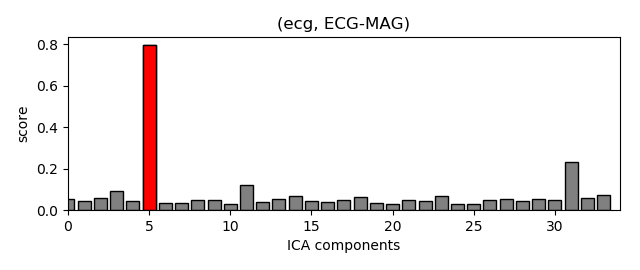

<IPython.core.display.Javascript object>


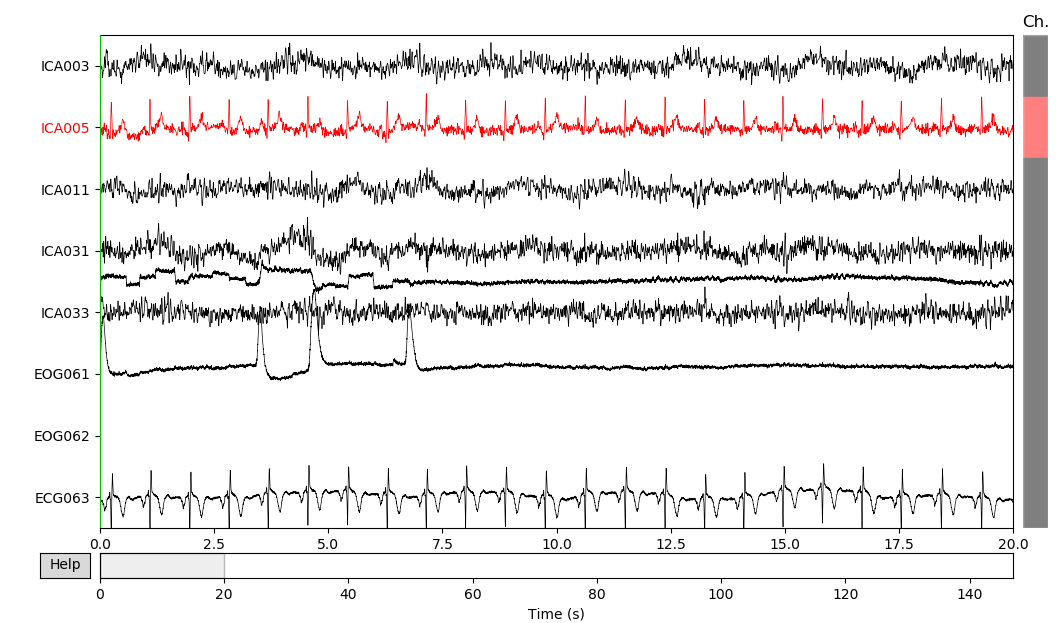

<IPython.core.display.Javascript object>


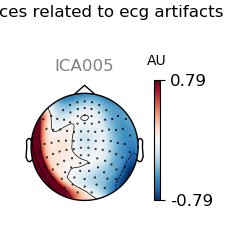

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
... filtering target
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
... filtering target
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected


<IPython.core.display.Javascript object>


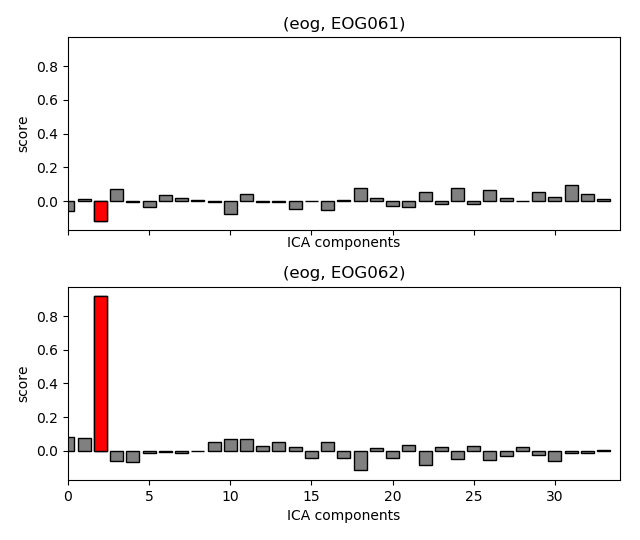

<IPython.core.display.Javascript object>


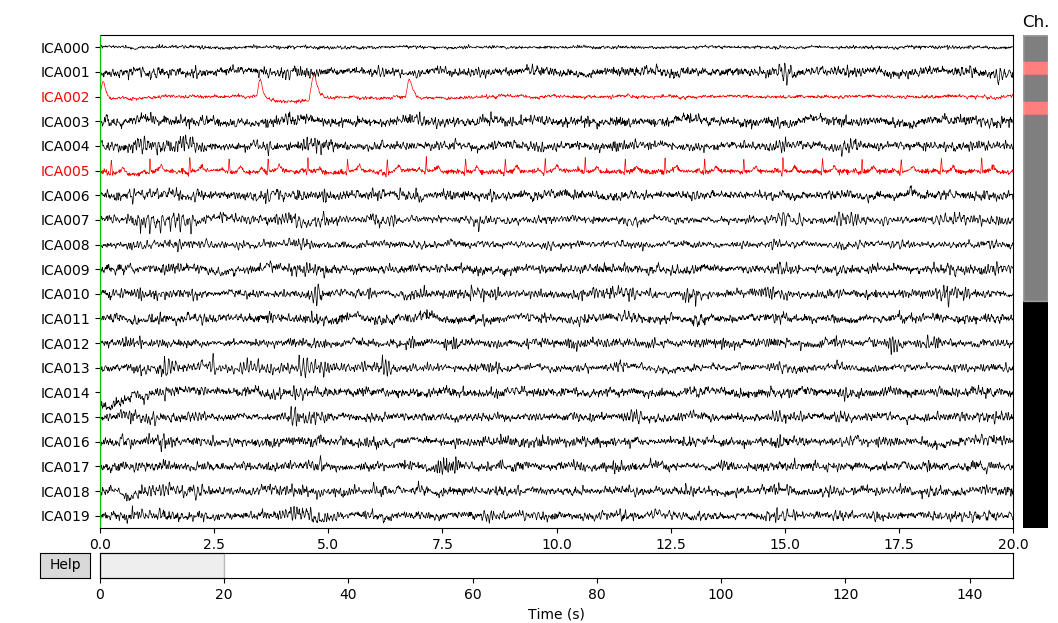

<IPython.core.display.Javascript object>


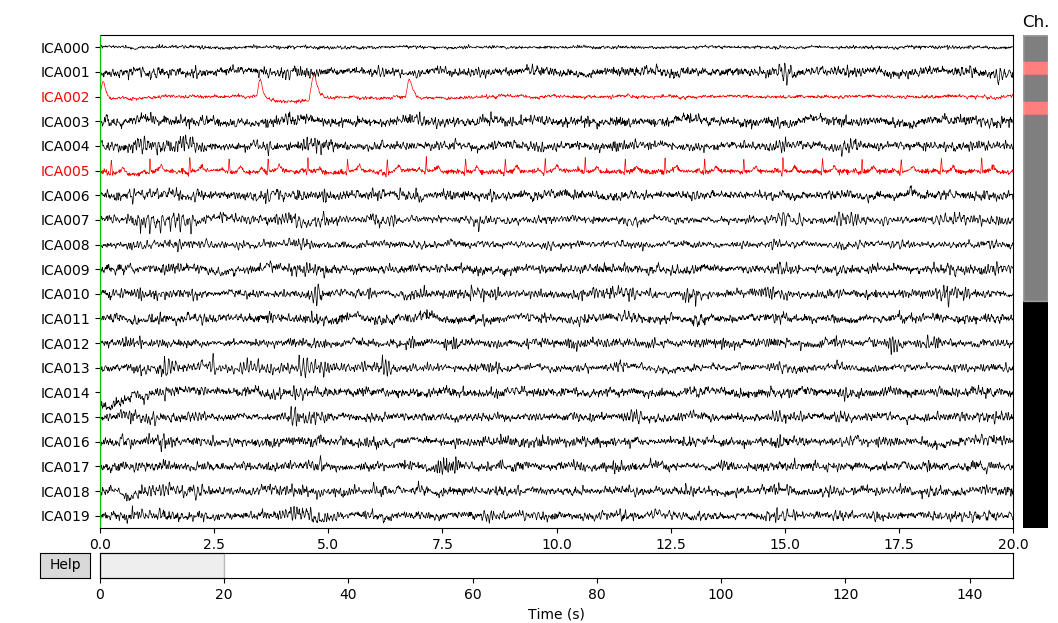

<IPython.core.display.Javascript object>


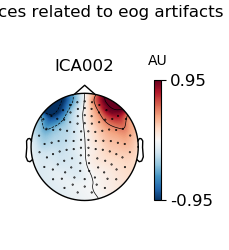

In [94]:
# maximum number of components to reject
n_max_ecg, n_max_eog = 3, 2
title = 'Sources related to %s artifacts (red)'

ecg_epochs = create_ecg_epochs(raw_sss, tmin=-0.5, tmax=0.5, picks=picks_ica)

ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, method='ctps')
_ = ica.plot_scores(scores, exclude=ecg_inds, title=title % 'ecg', labels='ecg')

show_picks = np.abs(scores).argsort()[::-1][:5]

_ = ica.plot_sources(raw_sss, show_picks, exclude=ecg_inds, title=title % 'ecg')
_ = ica.plot_components(ecg_inds, title=title % 'ecg', colorbar=True)

ecg_inds = ecg_inds[:n_max_ecg]
ica.exclude += ecg_inds

# detect EOG by correlation
eog_inds, scores = ica.find_bads_eog(raw_sss)
_ = ica.plot_scores(scores, exclude=eog_inds, title=title % 'eog', labels='eog')

# I had an error here, because in the next plot funtion if couldn't understand why 
# do I have array that consists of two arrays
# maybe it was because I have two EOG channels and only one ECG channel
show_picks  = np.abs(scores).argsort()[::-1][:5]

_ = ica.plot_sources(raw_sss, show_picks[0], exclude=eog_inds, title=title % 'eog 1')
_ = ica.plot_sources(raw_sss, show_picks[1], exclude=eog_inds, title=title % 'eog 2')
_ = ica.plot_components(eog_inds, title=title % 'eog', colorbar=True)

eog_inds = eog_inds[:n_max_eog]
ica.exclude += eog_inds

<IPython.core.display.Javascript object>


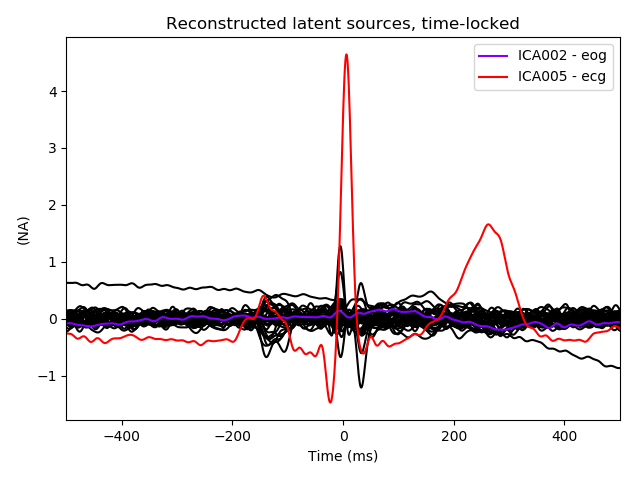

Transforming to ICA space (34 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


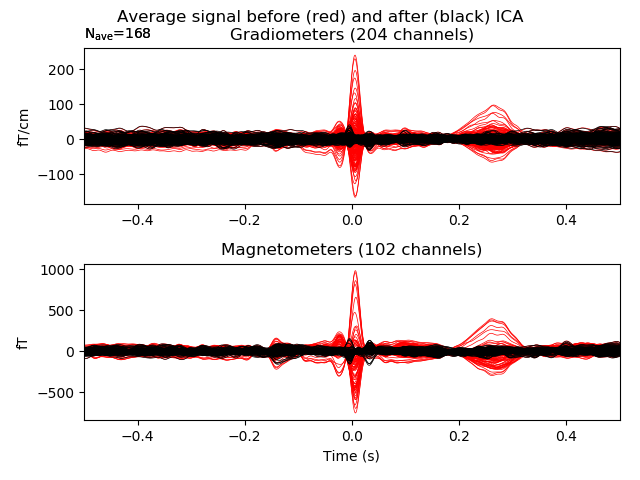

EOG channel index for this subject is: [320 321]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (16.384 sec) selected
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (16.384 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 17
17 matching events found
No baseline correction applied
Not setting metadata
Loading data for 17 events and 1001 original time points ...
2 bad epochs dropped


<IPython.core.display.Javascript object>


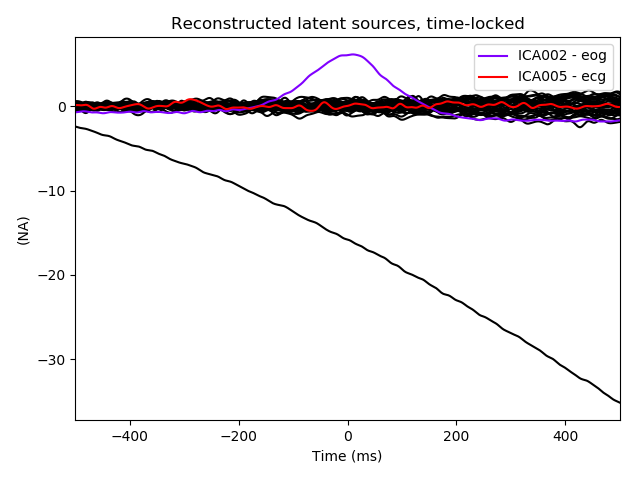

Transforming to ICA space (34 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


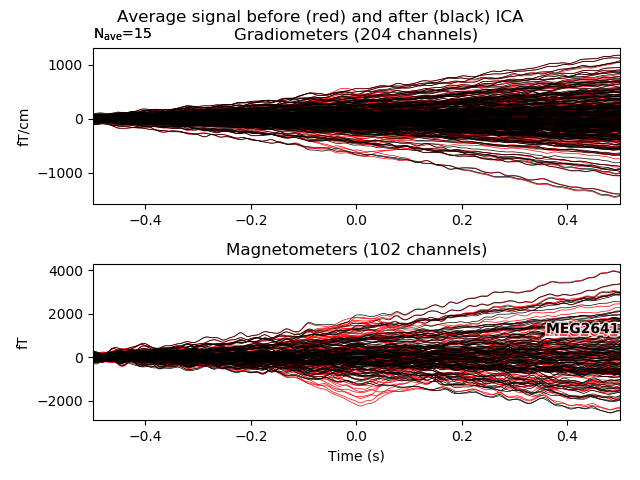

Transforming to ICA space (34 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


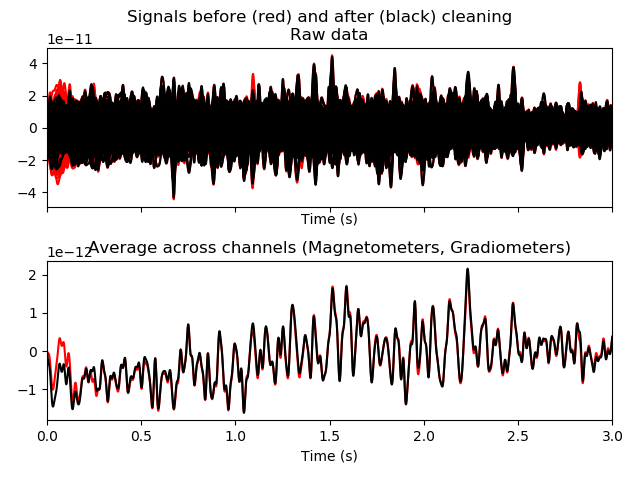

In [96]:
# estimate average artifact
ecg_evoked = ecg_epochs.average()
_ = ica.plot_sources(ecg_evoked, exclude=ecg_inds)  # plot ECG sources + selection
_ = ica.plot_overlay(ecg_evoked, exclude=ecg_inds)  # plot ECG cleaning

eog_evoked = create_eog_epochs(raw_sss, tmin=-.5, tmax=.5, picks=picks).average()
_ = ica.plot_sources(eog_evoked, exclude=eog_inds)  # plot EOG sources + selection
_ = ica.plot_overlay(eog_evoked, exclude=eog_inds)  # plot EOG cleaning

# check the amplitudes do not change
_ = ica.plot_overlay(raw_sss)  # EOG artifacts remain

<IPython.core.display.Javascript object>


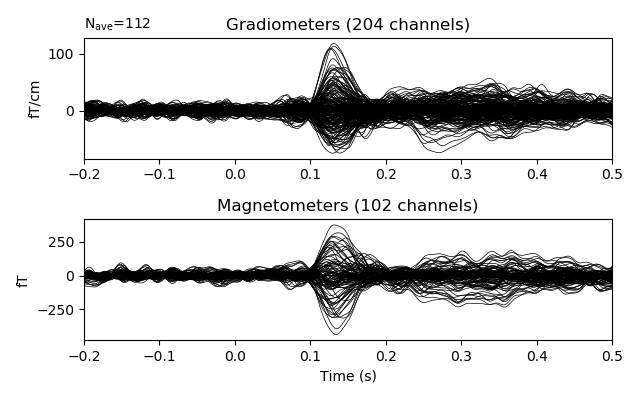

Transforming to ICA space (34 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


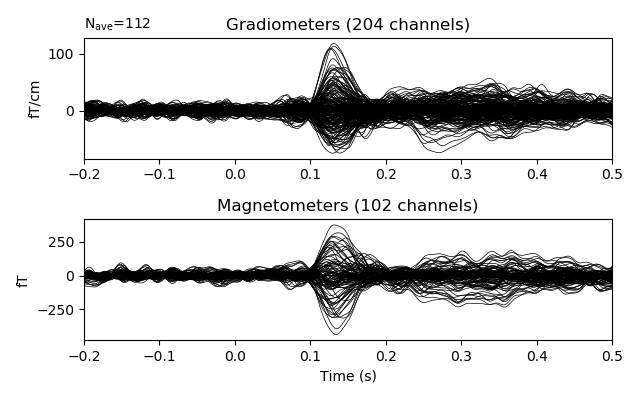

In [100]:
# Apply the solution to Raw, Epochs or Evoked like this:

_ = evoked_total.plot()

evoked_total_clean = ica.apply(evoked_total)

_ = evoked_total_clean.plot()